### INIT and Graphic SETTINGS

In [1]:
"""
===-*- Compressor Map Plotting Tool -*-===
=====-*- General -*-=====
Copyright (c) makkiblog.com
MIT License 
coding: utf-8

===-*- VERSION -*-===
v3.0 Initial Release with Interpolation
vvvCODEvvv
"""

#Init Setup
import math
import numpy as np
from pylab import *
from scipy import interpolate
from scipy.ndimage.filters import gaussian_filter1d
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
import sys
import configparser
import codecs
import json
import csv

#from scipy.interpolate import BSpline
#import scipy.optimize as opt
#import scipy.fftpack
#from scipy import signal
#from scipy import integrate
#from scipy import stats
#import matplotlib as mpl
#from matplotlib.colors import LogNorm

mpl.rcParams['agg.path.chunksize'] = 100000

In [2]:
#Setup (Visual)
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_style('whitegrid')

plt.rcParams["figure.figsize"] = (25,20)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False

### CURVEFIT DEFINITION (OPTION)

In [3]:
#============DEFINE CURVEFIT Method===================
#====================NOT USED=========================
#Reference: https://rikei-fufu.com/2020/07/05/post-3270-fitting/

def fitfunc(X,C0,D2,D1,E2,E1): # 2D Gaussian
    y, bet = X #NC, WC, PRC
    z = C0+D2*y**2+D1*y+E2*bet**2+E1*bet
    return z
    
def fitting_curve(in_df):
    #x_obs = in_df['NC']
    y_obs = in_df['WC']
    bet_obs = in_df['PRC']
    z_obs = in_df['ETAC']
 
    #main calc
    popt, pcov = curve_fit(fitfunc, (y_obs, bet_obs), z_obs) 
    perr = np.sqrt(np.diag(pcov)) 
 
    #Chi2 contingency
    o = z_obs
    e = fitfunc((y_obs, bet_obs), popt[0], popt[1], popt[2], popt[3], popt[4]) 
    chi2 = stats.chisquare(o, f_exp = e, ddof=4) #ChiSq. Calc: Output: [chi**2, p value]
 
    #R2 calc
    residuals =  o - e 
    rss = np.sum(residuals**2)      #: residual sum of squares = rss
    tss = np.sum((o-np.mean(o))**2) #: total sum of squares = tss
    r_squared = 1 - (rss / tss)     #R^2
    statistics_numbers = {  "X-squared": format(chi2[0], '.3f'),
                            "p-value": format(chi2[1], '.5f'),
                            "R^2": format(r_squared, '.4f')}

    #Print results
    print("==========Fit Result============")
    print("T1t = C0 + [Dn*WC^n] + [En*PRC^n]")
    print("Constants:",popt)
    print('Error:',perr)   
    print("X-squared, p-value, R^2:", statistics_numbers)
    print("=============EOF=============") 
    return popt,perr,statistics_numbers


def EtaC_fit(WC,PRC,Cs,Error):
    EtaC = Cs[0]+Cs[1]*WC**2+Cs[2]*WC+Cs[3]*PRC**2+Cs[4]*PRC
    ERRmax = 0
    #ERRmax = np.sqrt(Error[0]**2+Error[1]**2*NC**2+Error[2]**2*NC+Error[3]**2*WC**2+Error[4]**2*WC+Error[5]**2*PRC**2+Error[6]**2*PRC)
    return EtaC,ERRmax

### FUNCTIONS DEFINITIONS

In [4]:
#===========Read Datas================
#csv data for test result
def csv_df(data):
    return pd.read_csv('./Data/' + data  +'.csv', skiprows=1, names=["WC","PRC"])

#text data (Option)
def test_data(data):   
    return pd.read_table('./Data/' + data+'.txt', skiprows=1, header=0,index_col=False)

#map data in .txt form
def map_array(cmap):   
    return pd.read_table('./Data/' + cmap +'.txt', skiprows=9, header=0, names=["NC","WC","PRC","ETAC"])

def map_csv(cmap):
    return pd.read_csv('./Data/' + cmap  +'.csv', skiprows=1, names=["NC","WC","PRC","ETAC"])

### 1D Interpolation Function

In [5]:
 #========1D Interpolation method==========
def EtaC_Interpolate(df,pitch):
    rpmgrp=df.groupby('spdline')
    nmax=rpmgrp.ngroups
    
    #Interpolating for each speed line
    i=0
    n=pitch
    res_df = pd.DataFrame(columns=['NC','WC','PRC','ETAC'])
    while i < nmax:
        NC_CVF = []
        rpmdf_i=rpmgrp.get_group(i)
        rpmi=rpmdf_i['NC']
        wci=rpmdf_i['WC']
        prci=rpmdf_i['PRC']
        etaci=rpmdf_i['ETAC']

        wci_a = np.linspace(wci.min(), wci.max(), n)
        f_PRC = interpolate.interp1d(wci,prci, kind='cubic')
        f_EtaC = interpolate.interp1d(wci,etaci, kind='cubic')        
        prci_a = f_PRC(wci_a)
        etaci_a = f_EtaC(wci_a)
        rpmi_a = rpmi.min()
        #print('Calculating for [rpm]:', rpmi_a)
        for wc in range(0,len(wci_a)):
                NC_CVF.append(rpmi_a)
        NCarray = array(NC_CVF)
        dfi = pd.DataFrame(
            {
                "NC": NCarray,
                "WC": wci_a,
                "PRC": prci_a,
                "ETAC": etaci_a
            }
            )
        dfi = dfi.dropna()
        res_df = pd.concat([res_df, dfi])
        i+=1
    res_df = res_df.dropna()
    res_df = res_df.reset_index(drop=True)
    toc1 = time.perf_counter()


    #Interpolating between speedlines 脳筋メソッド
    n=pitch
    #RES_ARR = np.zeros(shape=(int(len(res_df.iloc[:,0])/nmax*n),4))
    res_arr = pd.DataFrame(columns=['NC','WC','PRC','ETAC'])
    j=0
    for j in range(n):
        dfarr_j = pd.DataFrame(columns=['NC','WC','PRC','ETAC'])
        k=0
        for k in range(nmax):
            dfarr_k = res_df.iloc[k*n+j,:]
            dfarr_j = pd.concat([dfarr_j,dfarr_k], axis=1)
        dfarr_j = dfarr_j.transpose()
        dfarr_j = dfarr_j.dropna()
        dfarr_j = dfarr_j.reset_index(drop=True)

        rpmj = dfarr_j['NC']
        wcj = dfarr_j['WC']
        prcj = dfarr_j['PRC']
        etacj = dfarr_j['ETAC']

        rpmj_a = np.linspace(rpmj.min(), rpmj.max(), n)
        f_WCj = interpolate.interp1d(rpmj,wcj, kind='slinear')
        f_PRCj = interpolate.interp1d(rpmj,prcj, kind='slinear')
        f_EtaCj = interpolate.interp1d(rpmj,etacj, kind='slinear')
        #f_EtaCj = interpolate.interp1d(wcj,etacj, kind='slinear') #wcj interpolation option

        wcj_a = f_WCj(rpmj_a)
        prcj_a = f_PRCj(rpmj_a)
        etacj_a = f_EtaCj(rpmj_a)
        #etacj_a = f_EtaCj(wcj_a) #wcj interpolation option
        
        res_arr_j = pd.DataFrame(
            {
                "NC": rpmj_a,
                "WC": wcj_a,
                "PRC": prcj_a,
                "ETAC": etacj_a
            }
            )
        res_arr_j = res_arr_j.dropna()
        res_arr = pd.concat([res_arr, res_arr_j])
    res_arr = res_arr.reset_index(drop=True)
    toc2 = time.perf_counter()
    return(res_arr,n,toc1,toc2)
    

### Plotting Function Option 1 (1D Interpolation)

In [6]:
#============================OPTION 1 =========================================
#=================Plotting with curve fit method===============================
#==============================================================================

tic = time.perf_counter()

def Interpolate_plot(df,data1,data2,color1,color2,xlim,ylmin,ylmax,etamin,etamax,elevation,azimuth,pitch):
    df['spdline']=df.groupby('NC').ngroup()
    rpmgrp=df.groupby('spdline')
    nmax=rpmgrp.ngroups
    
    #Run Calc===============================
    result_interp,n,toc1,toc2 = EtaC_Interpolate(df,pitch)
    print('\n =======Interpolation Result======== \n',result_interp, "\n ===============END CALC===============")
    result_interp_sorted = result_interp.sort_values(by=['NC'])
    result_interp_sorted = result_interp_sorted.reset_index(drop=True)
    result_interp_sorted.to_csv('./Data/' + cmapname +'_' + str(n) + '_interp.csv')
    result_interp.to_csv('./Data/' + cmapname +'_' + str(n) + '_interp_def.csv')
    df.to_csv('./Data/' + cmapname + '_orres.csv')
    toc3 = time.perf_counter()

    result_interp['spdline']=result_interp.groupby('NC').ngroup()
    cvfgrp=result_interp.groupby('spdline')

    #Plot Settings============================
    datax1=data1['WC']
    datay1=data1['PRC']
    datax2=data2['WC']
    datay2=data2['PRC']

    plt.figure(0)
    plt.title("Compressor Map_"  + cmapname + '_' + name1 + '_' + name2)
    plt.xlabel('Air Flow [kg/s]')
    plt.ylabel('PRC [-]')
    plt.axis ([0,xlim,ylmin,ylmax])
    plt.xticks(np.arange(0, xlim, xlim/20))
    plt.yticks(np.arange(ylmin, ylmax, (ylmax-ylmin)/20))
    
    plt.figure(1)
    plt.title("Flow-EtaC_"  + cmapname + '_' + name1 + '_' + name2)
    plt.xlabel('Air Flow [kg/s]')
    plt.ylabel('EtaC [-]')
    plt.axis ([0,xlim,etamin,etamax])
    plt.xticks(np.arange(0, xlim, xlim/20))
    plt.yticks(np.arange(etamin,etamax, (etamax-etamin)/20))
    
    #=========Plot Main=================
    x=result_interp['WC']
    y=result_interp['PRC']
    z=result_interp['ETAC']
    n=100
    xi, yi = np.linspace(x.min(), x.max(), n), np.linspace(y.min(), y.max(), n)
    Y,X=np.meshgrid(yi,xi)
    z =  gaussian_filter1d(z, sigma=2) #Gaussian filter option
    Z = interpolate.griddata((y,x),z,(Y,X),method='cubic')

    plt.figure(0)
    plt.contourf(X,Y,Z, 30 ,cmap='bwr',alpha=0.3)
    plt.colorbar()
    #plt.imshow(Z, extent=[x.min(),x.max(),y.min(),y.max()], origin='lower' ,cmap='bwr', aspect=0.1)
    plt.contour(X,Y,Z, 10 ,colors='slategrey') 

    #=========Plotting Others===========
    #Plot map speedlines
    surgelinex=list()
    surgeliney=list()
    chokelinex=list()
    chokeliney=list()
    i=0
    while i < nmax:
        rpmi=rpmgrp.get_group(i)
        wci=rpmi['WC']
        prci=rpmi['PRC']
        chokelinex.append(wci.max())
        chokeliney.append(prci.min())
        surgelinex.append(wci.min())
        surgeliney.append(prci.max())
        revi=str(int(rpmi['NC'].iloc[0]))
        plt.figure(0)
        plt.plot(wci, prci,"midnightblue", label=revi + ' rpm', linewidth=1)   
        
        #plt EtaC
        plt.figure(1)
        plt.plot(wci,rpmi['ETAC'],"red", label=revi+'rpm')
        i+=1

    #Print flow-etaC 2D plot
    j=0
    while j < pitch:
        cvfi = cvfgrp.get_group(j)
        wcres = cvfi['WC']
        #prcres = cvfi['PRC']
        etacres = cvfi['ETAC']
        plt.figure(1)
        plt.plot(wcres,etacres,"blue", label=revi+'rpm')
        j+=1

    #Surge line and choke line
    plt.figure(0)
    plt.plot(surgelinex, surgeliney,"midnightblue", label = 'GS Surgeline', linewidth=4)
    plt.plot(chokelinex, chokeliney,"midnightblue", label = 'GS Chokeline', linewidth=4)   
    #plot datas
    plt.plot(datax1, datay1,color1, label = name1, linewidth=1)
    plt.plot(datax2, datay2,color2, label = name2, linewidth=1)
    plt.legend()
    plt.savefig('./Data/FIT_CMaP' + cmapname + '_' + name1 + '_' + name2 + '.png', dpi=300)
    
    plt.figure(1)
    plt.legend
    plt.savefig('./Data/FIT_EtaC' + cmapname + '_' + name1 + '_' + name2 + '.png', dpi=300)
    
    #3D plot
    fig, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax1.plot_surface(Y, X, Z, cmap=cm.coolwarm, linewidth=0, antialiased=True)
    ax1.view_init(elev=elevation, azim=azimuth)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.savefig('./Data/FIT_3D_Map' + cmapname + '_' + name1 + '_' + name2 + '.png', dpi=300)
    plt.show()
    toc4 = time.perf_counter()

    print("====Execution TIMER====")
    print(f"Interp Spdlines: {toc1-tic:0.4f}sec")
    print(f"Interp WC,PRC: {toc2-tic:0.4f}sec")
    print(f"Export csv: {toc3-tic:0.4f}sec")
    print(f"Plot results: {toc4-tic:0.4f}sec")

### Plotting Function (Option 2 Discrete)

In [7]:
#============================OPTION 2 =========================================
#=====================Plotting with meshgrid method============================
#==============================================================================
def all_datas_plot(cmap,data1,data2,color1,color2,xlim,ylmin,ylmax,etamin,etamax,elevation,azimuth):
    df=cmap
    datax1=data1['WC']
    datay1=data1['PRC']
    datax2=data2['WC']
    datay2=data2['PRC']
    df['spdline']=df.groupby('NC').ngroup()
    rpmgrp=df.groupby('spdline')
    nmax=rpmgrp.ngroups
    surgelinex=list()
    surgeliney=list()
    chokelinex=list()
    chokeliney=list()
      
    #plot setting
    plt.figure(0)
    plt.title("Compressor Map_"  + cmapname + '_' + name1 + '_' + name2)
    plt.xlabel('Air Flow [kg/s]')
    plt.ylabel('PRC [-]')
    plt.axis ([0,xlim,ylmin,ylmax])
    plt.xticks(np.arange(0, xlim, xlim/20))
    plt.yticks(np.arange(ylmin, ylmax, (ylmax-ylmin)/20))
    
    plt.figure(1)
    plt.title("Flow-EtaC_"  + cmapname + '_' + name1 + '_' + name2)
    plt.xlabel('Air Flow [kg/s]')
    plt.ylabel('EtaC [-]')
    plt.axis ([0,xlim,etamin,etamax])
    plt.xticks(np.arange(0, xlim, xlim/20))
    plt.yticks(np.arange(etamin,etamax, (etamax-etamin)/20))
    
    plt.figure(2)
    plt.title("Flow-PRC_"  + cmapname + '_' + name1 + '_' + name2)
    plt.xlabel('Air Flow [kg/s]')
    plt.ylabel('PRC [-]')
    plt.axis ([0,xlim,ylmin,ylmax])
    plt.xticks(np.arange(0, xlim, xlim/20))
    plt.yticks(np.arange(ylmin, ylmax, (ylmax-ylmin)/20))  

    """
    #plot efficiency contour Option
    j=0
    while j<nmax:
        rpmj=rpmgrp.get_group(j)
        x=rpmj['WC']
        y=rpmj['PRC']
        z=rpmj['ETAC']
        n=20
        xj, yj = np.linspace(x.min(), x.max(), n), np.linspace(y.min(), y.max(), n)
        Xj,Yj=np.meshgrid(xj,yj)
        Zj = interpolate.griddata((x,y),z,(Xj,Yj),method='linear')

        plt.figure(0)
        plt.contour(Xj,Yj,Zj, 2 ,colors='slategrey')
        #plt.contourf(X,Y,Z, 7 ,cmap='bwr',alpha=0.3)              
        j+=1
    """
    
    plt.figure(0)
    x=df['WC']
    y=df['PRC']
    z=df['ETAC']
    n=300
    xi, yi = np.linspace(x.min(), x.max(), n), np.linspace(y.min(), y.max(), n)
    zi =  gaussian_filter1d(z, sigma=2)
    Y,X=np.meshgrid(yi,xi)
    Z1 = interpolate.griddata((y,x),z,(Y,X),method='cubic')
    Z2 = interpolate.griddata((y,x),zi,(Y,X),method='cubic')  #with gaussian filter
    Z2_Trisurf = interpolate.griddata((y,x),z,(Y.ravel(),X.ravel()),method='cubic')  #for trisurf plot with no filter
    #Z2_Trisurf = interpolate.griddata((y,x),zi,(Y.ravel(),X.ravel()),method='cubic')  #for trisurf plot with gaussian filter
    plt.contourf(X,Y,Z1, 14 ,cmap='bwr',alpha=0.3)
    #plt.contourf(X,Y,Z2, 14 ,cmap='bwr',alpha=0.4)
    plt.colorbar()
    #plt.imshow(Z1, extent=[x.min(),x.max(),y.min(),y.max()], origin='lower' ,cmap='bwr', aspect=0.1)
    plt.contour(X,Y,Z1, 7 ,colors='slategrey') #no filter
    #plt.contour(X,Y,Z2, 7 ,colors='slategrey') #with gaussian filter

  

    #Plot speedlines
    i=0
    while i<nmax:
        rpmi=rpmgrp.get_group(i)
        wci=rpmi['WC']
        prci=rpmi['PRC']
        chokelinex.append(wci.max())
        chokeliney.append(prci.min())
        surgelinex.append(wci.min())
        surgeliney.append(prci.max())
        revi=str(int(rpmi['NC'].iloc[0]))
        plt.figure(0)
        plt.plot(wci, prci,"midnightblue", label=revi + ' rpm', linewidth=1)   
        
        #plt EtaC
        plt.figure(1)
        plt.plot(wci,rpmi['ETAC'],"red", label=revi+'rpm(Flow-EtaC)')
                
        #plt PRC
        plt.figure(2)
        plt.plot(wci,prci,"blue", label=revi+'rpm(Flow-PRC)')  
        i+=1   
    
    #Surge line and choke line
    plt.figure(0)
    plt.plot(surgelinex, surgeliney,"midnightblue", label = 'GS Surgeline', linewidth=4)
    plt.plot(chokelinex, chokeliney,"midnightblue", label = 'GS Chokeline', linewidth=4)   
    
    #plot datas
    plt.plot(datax1, datay1,color1, label = name1, linewidth=1)
    plt.plot(datax2, datay2,color2, label = name2, linewidth=1)
    plt.legend()
    plt.savefig('./Data/CMaP' + cmapname + '_' + name1 + '_' + name2 + '.png', dpi=300)
    
    plt.figure(1)
    plt.legend
    plt.savefig('./Data/EtaC' + cmapname + '_' + name1 + '_' + name2 + '.png', dpi=300)
    
    plt.figure(2)
    plt.legend
    plt.savefig('./Data/PRC' + cmapname + '_' + name1 + '_' + name2 + '.png', dpi=300)

    
    #3D plot
    fig, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax1.plot_surface(Y, X, Z1, cmap=cm.coolwarm, linewidth=0, antialiased=True)
    ax1.view_init(elev=elevation, azim=azimuth)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.savefig('./Data/3D_Map' + cmapname + '_' + name1 + '_' + name2 + '.png', dpi=300)
    plt.show()
        
    fig, ax2 = plt.subplots(subplot_kw={"projection": "3d"})
    surf2 = ax2.plot_trisurf(Y.ravel(), X.ravel(), Z2_Trisurf, cmap=cm.coolwarm, edgecolor='none')
    ax2.view_init(elev=elevation, azim=azimuth)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.savefig('./Data/3D_Map_Trisurf' + cmapname + '_' + name1 + '_' + name2 + '.png', dpi=300)
    plt.show()

### Plot Data


 =======Interpolation Result======== 
                  NC        WC       PRC      ETAC
0      50415.714300  0.059900  1.304300  0.633600
1      52103.873192  0.059753  1.332740  0.632877
2      53792.032084  0.059606  1.361180  0.632155
3      55480.190976  0.059459  1.389620  0.631432
4      57168.349867  0.059312  1.418061  0.630709
...             ...       ...       ...       ...
2495  126382.864433  0.369391  2.132130  0.576349
2496  128071.023324  0.371718  2.170922  0.576337
2497  129759.182216  0.374045  2.209715  0.576324
2498  131447.341108  0.376373  2.248507  0.576312
2499  133135.500000  0.378700  2.287300  0.576300

[2500 rows x 4 columns] 
 ===============END CALC===============


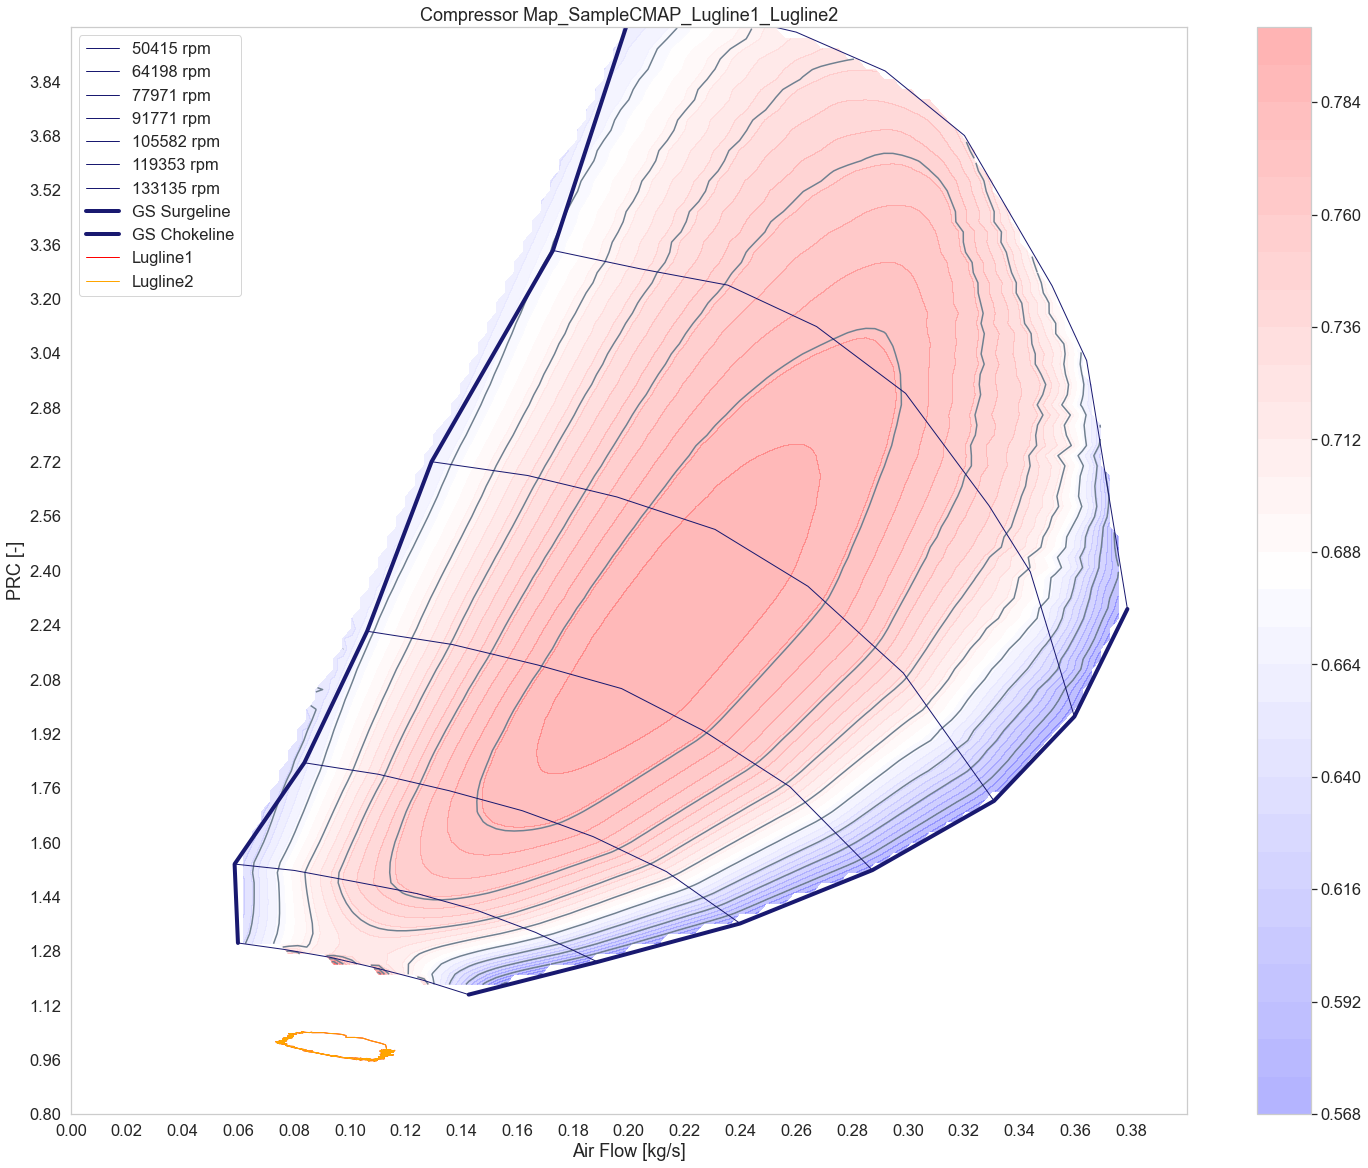

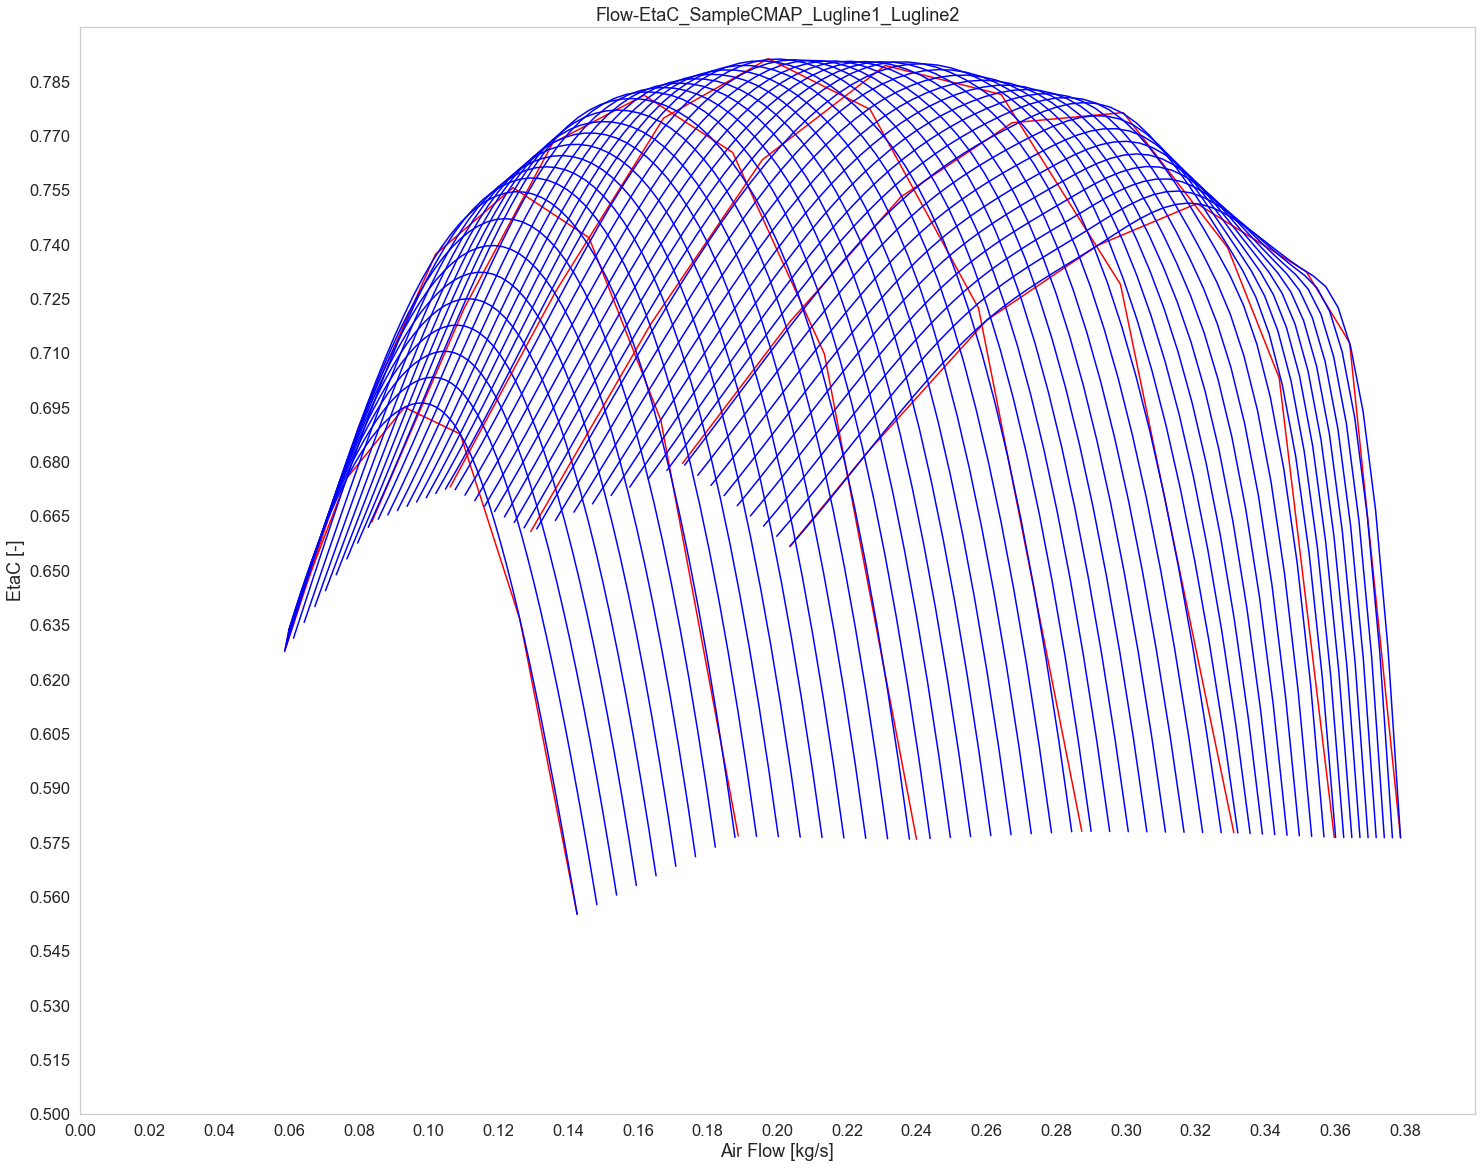

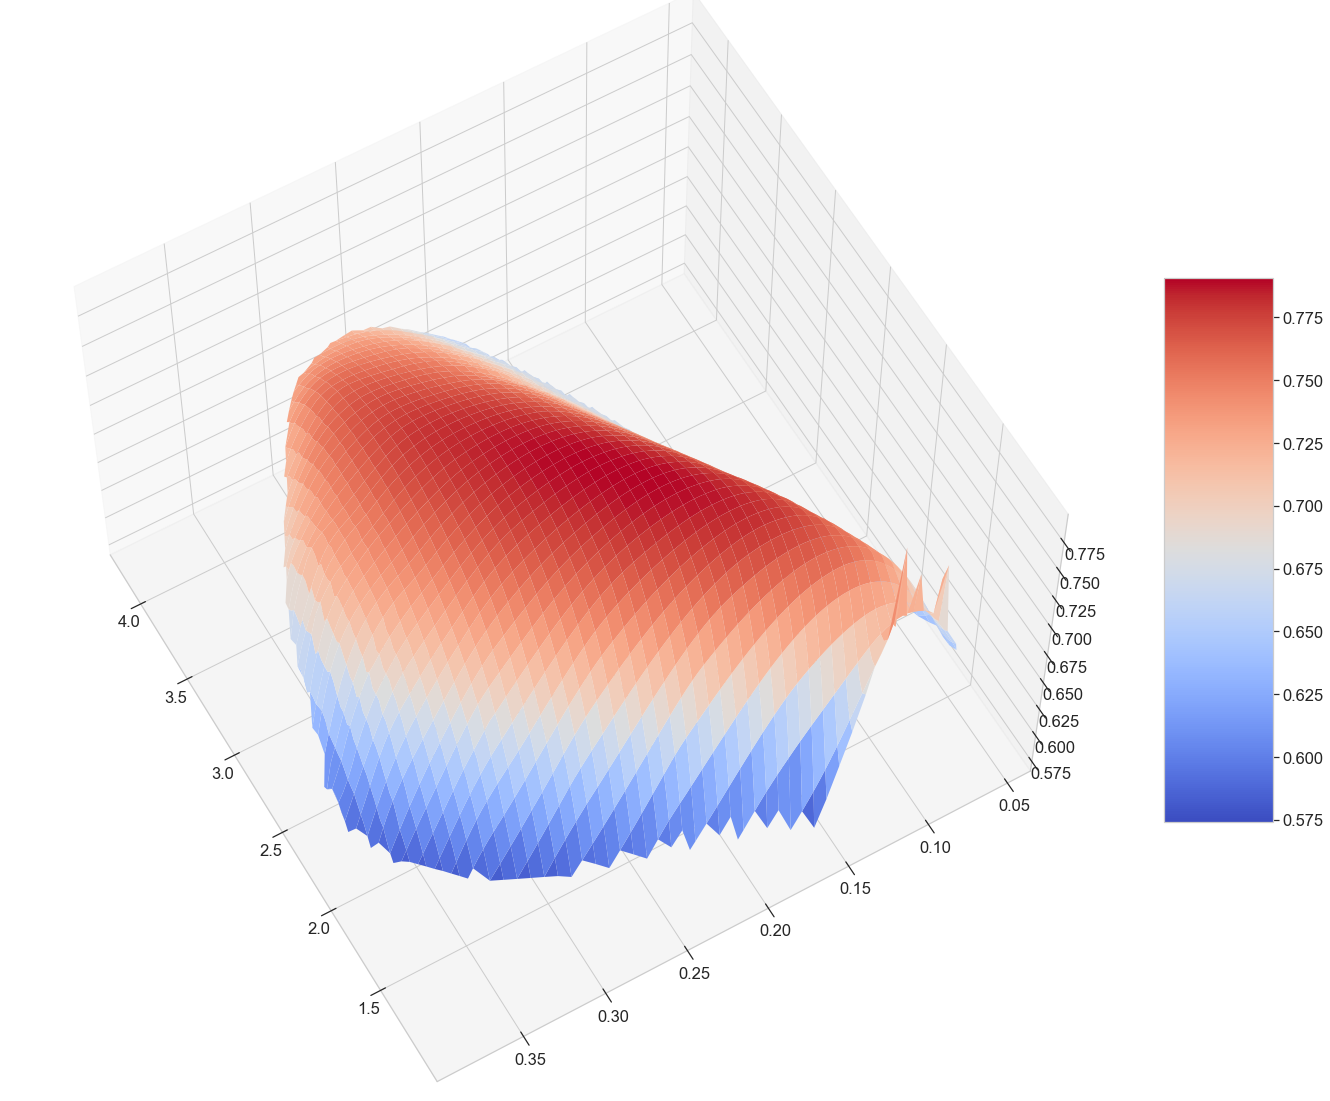

====Execution TIMER====
Interp Spdlines: 0.1888sec
Interp WC,PRC: 0.7235sec
Export csv: 0.7695sec
Plot results: 11.9153sec


In [8]:
#======================INPUT DATA SETTINGS==========================
#specify data names
cmapname = "SampleCMAP"  #map name
cmap1 = "cmap_1" #.csv file for compressor map
name1 = "Lugline1" #.csv file for 1st data set
name2 = "Lugline2" #.csv file for 2nd data set
color1 = "red" #plotting color for 1st data set
color2 = "orange" #plotting color for 2nd data set

#===============Option 1 (Curve fit Plotting)====================
#curvefit_plot(map_array(cmapname),csv_df(name1),csv_df(name2),color1, color2, 0.4,0.8,4.0,0.4,0.8) 
#Syntax: map name, 1st dataset, 2nd dataset, color1, color2, xrange(air flow max), yrange(PRCmin, PRCmax), yrange(etamin,etamax)3D (elevation, azimuth), pitch(no. for interpolation)

Interpolate_plot(map_array(cmapname),csv_df(name1),csv_df(name2),color1, color2, 0.4,0.8,4.0,0.5,0.8,60,150,50) 


#===============Option 2 (Discrete Plotting)====================
#all_datas_plot(map_array(cmapname),csv_df(name1),csv_df(name2),color1, color2, 0.4,0.8,4.0,0.4,0.8,30,120) 
#Syntax: map name, 1st dataset, 2nd dataset, color1, color2, xrange(air flow max), yrange(PRCmin, PRCmax), yrange(etamin,etamax), 3D (elevation, azimuth)

#all_datas_plot(map_csv(cmap1),csv_df(name1),csv_df(name2),color1, color2, 2.0,2.0,12.0,0.6,0.9,20,150) 

